<a href="https://colab.research.google.com/github/nht0017/HIDS/blob/main/NSL_KDD_multiclass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import tensorflow as tf

from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
from glob import glob
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split

import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score, roc_curve, auc, recall_score, precision_score,plot_confusion_matrix
from sklearn.preprocessing import LabelEncoder


## **Get Data from Kaggle**

In [4]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d kiranmahesh/nslkdd

! unzip nslkdd.zip

Saving kaggle.json to kaggle.json
  0% 0.00/2.56M [00:00<?, ?B/s]
100% 2.56M/2.56M [00:00<00:00, 86.1MB/s]
Archive:  nslkdd.zip
  inflating: kdd_test.csv            
  inflating: kdd_train.csv           


# **Data Process**

In [5]:
# Get a list of files from this dir
files_list = os.listdir()

#files_list.sort()

files_list

['.config',
 'kdd_train.csv',
 'kaggle.json',
 'kdd_test.csv',
 'nslkdd.zip',
 'sample_data']

## **Read in Data**

Since Test and Train data comtain some different labels, we combine them together and then split into training and testing sets later

In [6]:
#INDEX =  0#@param {type:"integer"}

# Get df name
DATA = 'NSL-KDD'
print('DATA:', DATA)
csv_file = ['kdd_train.csv', 'kdd_test.csv']

list_of_dataframes = []
for filename in csv_file:
    list_of_dataframes.append(pd.read_csv(filename, sep=',', header=0))

df = pd.concat(list_of_dataframes, ignore_index=True)
df

#test_df = pd.read_csv('kdd_test.csv', sep=',', header=0, engine='python')

DATA: NSL-KDD


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,labels
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.00,0.0,0.00,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.00,0.0,0.00,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.00,1.0,0.00,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune
3,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.20,0.2,0.00,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.00,0.0,0.00,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148512,0,tcp,private,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,395,1,0.06,0.0,0.93,1.0,0.00,1.00,0.00,255,1,0.00,1.00,0.00,0.00,0.09,0.00,0.91,1.00,satan
148513,0,tcp,http,SF,254,2277,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,2,0.00,0.0,0.00,0.0,1.00,0.00,0.00,27,255,1.00,0.00,0.04,0.04,0.00,0.00,0.00,0.00,normal
148514,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,202,10,1.00,1.0,0.00,0.0,0.05,0.07,0.00,255,25,0.10,0.07,0.00,0.00,1.00,1.00,0.00,0.00,neptune
148515,0,tcp,private,RSTR,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0.00,0.0,0.50,1.0,0.50,1.00,0.00,255,1,0.00,0.58,0.57,0.00,0.00,0.00,0.58,1.00,portsweep


In [7]:
df.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,148517.000000,1.485170e+05,1.485170e+05,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.0,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000,148517.000000
mean,282.850980,4.051230e+04,1.722710e+04,0.000182,0.021822,0.000121,0.196994,0.002370,0.397308,0.276231,0.001448,0.001098,0.298525,0.012147,0.000458,0.004101,0.0,0.000013,0.010208,84.046729,27.926702,0.276324,0.274494,0.125636,0.126641,0.664048,0.064439,0.096870,182.866870,116.787910,0.524935,0.083248,0.147277,0.031895,0.276092,0.270477,0.124323,0.125298
std,2545.220043,5.409528e+06,3.703596e+06,0.013482,0.248406,0.014678,2.087903,0.058437,0.489342,22.490762,0.038021,0.045155,22.999664,0.468356,0.023778,0.099098,0.0,0.003670,0.100516,115.287822,73.544207,0.442347,0.442972,0.326640,0.329570,0.438869,0.184633,0.258977,98.964628,110.868085,0.448749,0.190616,0.308485,0.111598,0.440218,0.441200,0.312011,0.324583
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,84.000000,11.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,14.000000,7.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,255.000000,65.000000,0.540000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,2.760000e+02,5.270000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,143.000000,18.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.060000,0.000000,255.000000,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000
max,54451.000000,1.379964e+09,1.309937e+09,1.000000,3.000000,3.000000,77.000000,5.000000,1.000000,7479.000000,1.000000,2.000000,7468.000000,43.000000,2.000000,9.000000,0.0,1.000000,1.000000,511.000000,511.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**Check for columns with only constant**

If Label only has 1 value, then we don't analyze this df.


In [8]:
# Print a list of column containing only constant if exists
filt = np.std(df, axis=0) == 0
if filt.any == True:
  print(df.loc[:,filt])

## **Encoding Label**

In [9]:
# If a class has < 2 instances --> drop it
filt = df['labels'].value_counts() < 2
drop_class = filt[filt == True].index[0] # Assuming only 1 class has 1 instance

print('A class with only 1 instance is ',drop_class)

print('df shape before dropping:', df.shape)

# Filter only classes that have only 1 instance and then drop it.
class_filt = df['labels'] == drop_class
df.drop(index = df[class_filt].index , inplace=True) 
print('df shape after dropping:', df.shape)


A class with only 1 instance is  xsnoop
df shape before dropping: (148517, 42)
df shape after dropping: (148516, 42)


In [10]:
OG_labels = sorted(df['labels'].unique())
n_classes = len(OG_labels)

# Encoding label for test data
print('Before encoding Label: ', OG_labels)
lb_make = LabelEncoder().fit(OG_labels)
df['encoded_labels'] = lb_make.transform(df['labels'])

df.drop(columns=['labels'], inplace=True)
print(df.shape)

encoded_labels = sorted( list(df['encoded_labels'].unique()))

labels_dict = dict(zip(range(len(lb_make.classes_)), lb_make.classes_, ))
labels_dict

Before encoding Label:  ['apache2', 'back', 'buffer_overflow', 'ftp_write', 'guess_passwd', 'httptunnel', 'imap', 'ipsweep', 'land', 'loadmodule', 'mailbomb', 'mscan', 'multihop', 'named', 'neptune', 'nmap', 'normal', 'perl', 'phf', 'pod', 'portsweep', 'processtable', 'ps', 'rootkit', 'saint', 'satan', 'sendmail', 'smurf', 'snmpgetattack', 'snmpguess', 'spy', 'teardrop', 'warezclient', 'warezmaster', 'xlock', 'xterm']
(148516, 42)


{0: 'apache2',
 1: 'back',
 2: 'buffer_overflow',
 3: 'ftp_write',
 4: 'guess_passwd',
 5: 'httptunnel',
 6: 'imap',
 7: 'ipsweep',
 8: 'land',
 9: 'loadmodule',
 10: 'mailbomb',
 11: 'mscan',
 12: 'multihop',
 13: 'named',
 14: 'neptune',
 15: 'nmap',
 16: 'normal',
 17: 'perl',
 18: 'phf',
 19: 'pod',
 20: 'portsweep',
 21: 'processtable',
 22: 'ps',
 23: 'rootkit',
 24: 'saint',
 25: 'satan',
 26: 'sendmail',
 27: 'smurf',
 28: 'snmpgetattack',
 29: 'snmpguess',
 30: 'spy',
 31: 'teardrop',
 32: 'warezclient',
 33: 'warezmaster',
 34: 'xlock',
 35: 'xterm'}

**Check if the df has infinity value**
if Yes, replace it with NaN value so that we can drop it altogether in a bit


In [11]:
# Removing NaN
df.dropna(axis=1, how='any', inplace=True)

df.shape

(148516, 42)

In [12]:
# Encoding protocol_type
print(df['protocol_type'].unique())

encoder = LabelEncoder().fit(df['protocol_type'])
df['encoded_protocol_type'] = encoder.transform(df['protocol_type'])

df.drop(columns=['protocol_type'], inplace=True)
print(df.shape)
df.head()

['tcp' 'udp' 'icmp']
(148516, 42)


,duration,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,encoded_labels,encoded_protocol_type
0,0,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,16,1
1,0,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,16,2
2,0,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,14,1
3,0,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,16,1
4,0,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,16,1


In [13]:
# Encoding service for train data
services = df['service'].unique().tolist()
services.sort()
print(len(services), services)

# Encoding label: 1 is normal, 0 is intrusion
encoder = LabelEncoder().fit(df['service'])
df['encoded_service'] = encoder.transform(df['service'])
#print(protocol_encoder.classes_)

df.drop(columns=['service'], inplace=True)
print(df.shape)
df.head()

70 ['IRC', 'X11', 'Z39_50', 'aol', 'auth', 'bgp', 'courier', 'csnet_ns', 'ctf', 'daytime', 'discard', 'domain', 'domain_u', 'echo', 'eco_i', 'ecr_i', 'efs', 'exec', 'finger', 'ftp', 'ftp_data', 'gopher', 'harvest', 'hostnames', 'http', 'http_2784', 'http_443', 'http_8001', 'imap4', 'iso_tsap', 'klogin', 'kshell', 'ldap', 'link', 'login', 'mtp', 'name', 'netbios_dgm', 'netbios_ns', 'netbios_ssn', 'netstat', 'nnsp', 'nntp', 'ntp_u', 'other', 'pm_dump', 'pop_2', 'pop_3', 'printer', 'private', 'red_i', 'remote_job', 'rje', 'shell', 'smtp', 'sql_net', 'ssh', 'sunrpc', 'supdup', 'systat', 'telnet', 'tftp_u', 'tim_i', 'time', 'urh_i', 'urp_i', 'uucp', 'uucp_path', 'vmnet', 'whois']
(148516, 42)


,duration,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,encoded_labels,encoded_protocol_type,encoded_service
0,0,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,16,1,20
1,0,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,16,2,44
2,0,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,14,1,49
3,0,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,16,1,24
4,0,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,16,1,24


In [14]:
# Encoding flag for train data
flags = df['flag'].unique().tolist()
flags.sort()
print(len(flags), flags)
encoder = LabelEncoder().fit(df['flag'])
df['encoded_flag'] = encoder.transform(df['flag'])

df.drop(columns=['flag'], inplace=True)
print(df.shape)

df.head()

11 ['OTH', 'REJ', 'RSTO', 'RSTOS0', 'RSTR', 'S0', 'S1', 'S2', 'S3', 'SF', 'SH']
(148516, 42)


,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,encoded_labels,encoded_protocol_type,encoded_service,encoded_flag
0,0,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,16,1,20,9
1,0,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,16,2,44,9
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,14,1,49,5
3,0,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,16,1,24,9
4,0,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,16,1,24,9


In [15]:
# Move col Labels to the last col
df['Labels'] = df['encoded_labels']
df.drop(columns=['encoded_labels'], inplace= True)
df

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,encoded_protocol_type,encoded_service,encoded_flag,Labels
0,0,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.00,0.0,0.00,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,1,20,9,16
1,0,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.00,0.0,0.00,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,2,44,9,16
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.00,1.0,0.00,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,1,49,5,14
3,0,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.20,0.2,0.00,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,1,24,9,16
4,0,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.00,0.0,0.00,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1,24,9,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148512,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,395,1,0.06,0.0,0.93,1.0,0.00,1.00,0.00,255,1,0.00,1.00,0.00,0.00,0.09,0.00,0.91,1.00,1,49,1,25
148513,0,254,2277,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,2,0.00,0.0,0.00,0.0,1.00,0.00,0.00,27,255,1.00,0.00,0.04,0.04,0.00,0.00,0.00,0.00,1,24,9,16
148514,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,202,10,1.00,1.0,0.00,0.0,0.05,0.07,0.00,255,25,0.10,0.07,0.00,0.00,1.00,1.00,0.00,0.00,1,49,5,14
148515,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0.00,0.0,0.50,1.0,0.50,1.00,0.00,255,1,0.00,0.58,0.57,0.00,0.00,0.00,0.58,1.00,1,49,4,20


## **Feature Selection**

In [16]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, chi2


r,c = df.shape
X = df.iloc[:,:c-1]
y = df['Labels']

bestfeatures = SelectKBest(score_func=f_classif, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
best_features = featureScores.nlargest(30,'Score')
print(best_features)  #print 30 best features


                          Specs          Score
4                wrong_fragment  229364.984731
25                same_srv_rate   29867.847264
3                          land   12119.298899
35     dst_host_srv_serror_rate   11153.392119
34         dst_host_serror_rate   10768.813084
22              srv_serror_rate   10600.441470
21                  serror_rate   10513.693226
30       dst_host_same_srv_rate    8530.772212
33  dst_host_srv_diff_host_rate    7239.594446
40                 encoded_flag    6717.131145
29           dst_host_srv_count    5974.809371
19                        count    5341.483175
8                     logged_in    4896.915190
20                    srv_count    4148.726909
32  dst_host_same_src_port_rate    3926.679257
31       dst_host_diff_srv_rate    3443.323255
38        encoded_protocol_type    2678.066619
26                diff_srv_rate    2596.176754
28               dst_host_count    2367.741339
27           srv_diff_host_rate    1607.541095
37     dst_ho

/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [16] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [17]:
best_column_indices = []

# Choose any features with scores above 1000
for index, row in best_features.iterrows():
 # print(row[ "Score"])
  if row[ "Score"] > 1000 :
    best_column_indices.append(index)

# Keep only columns w the best features
X = X.iloc[:, best_column_indices]
NUM_COLS = len(X.columns)
X 

,wrong_fragment,same_srv_rate,land,dst_host_srv_serror_rate,dst_host_serror_rate,srv_serror_rate,serror_rate,dst_host_same_srv_rate,dst_host_srv_diff_host_rate,encoded_flag,dst_host_srv_count,count,logged_in,srv_count,dst_host_same_src_port_rate,dst_host_diff_srv_rate,encoded_protocol_type,diff_srv_rate,dst_host_count,srv_diff_host_rate,dst_host_srv_rerror_rate,rerror_rate,srv_rerror_rate,num_failed_logins,duration,encoded_service,dst_host_rerror_rate
0,0,1.00,0,0.00,0.00,0.0,0.00,0.17,0.00,9,25,2,0,2,0.17,0.03,1,0.00,150,0.00,0.00,0.00,0.0,0,0,20,0.05
1,0,0.08,0,0.00,0.00,0.0,0.00,0.00,0.00,9,1,13,0,1,0.88,0.60,2,0.15,255,0.00,0.00,0.00,0.0,0,0,44,0.00
2,0,0.05,0,1.00,1.00,1.0,1.00,0.10,0.00,5,26,123,0,6,0.00,0.05,1,0.07,255,0.00,0.00,0.00,0.0,0,0,49,0.00
3,0,1.00,0,0.01,0.03,0.2,0.20,1.00,0.04,9,255,5,1,5,0.03,0.00,1,0.00,30,0.00,0.01,0.00,0.0,0,0,24,0.00
4,0,1.00,0,0.00,0.00,0.0,0.00,1.00,0.00,9,255,30,1,32,0.00,0.00,1,0.00,255,0.09,0.00,0.00,0.0,0,0,24,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148512,0,0.00,0,0.00,0.09,0.0,0.06,0.00,0.00,1,1,395,0,1,0.00,1.00,1,1.00,255,0.00,1.00,0.93,1.0,0,0,49,0.91
148513,0,1.00,0,0.00,0.00,0.0,0.00,1.00,0.04,9,255,2,1,2,0.04,0.00,1,0.00,27,0.00,0.00,0.00,0.0,0,0,24,0.00
148514,0,0.05,0,1.00,1.00,1.0,1.00,0.10,0.00,5,25,202,0,10,0.00,0.07,1,0.07,255,0.00,0.00,0.00,0.0,0,0,49,0.00
148515,0,0.50,0,0.00,0.00,0.0,0.00,0.00,0.00,4,1,2,0,1,0.57,0.58,1,1.00,255,0.00,1.00,0.50,1.0,0,0,49,0.58


In [18]:
X.describe()

,wrong_fragment,same_srv_rate,land,dst_host_srv_serror_rate,dst_host_serror_rate,srv_serror_rate,serror_rate,dst_host_same_srv_rate,dst_host_srv_diff_host_rate,encoded_flag,dst_host_srv_count,count,logged_in,srv_count,dst_host_same_src_port_rate,dst_host_diff_srv_rate,encoded_protocol_type,diff_srv_rate,dst_host_count,srv_diff_host_rate,dst_host_srv_rerror_rate,rerror_rate,srv_rerror_rate,num_failed_logins,duration,encoded_service,dst_host_rerror_rate
count,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000,148516.000000
mean,0.021823,0.664045,0.000182,0.270478,0.276094,0.274496,0.276326,0.524938,0.031895,6.972676,116.788568,84.047288,0.397304,27.926883,0.147278,0.083248,1.054324,0.064440,182.866385,0.096871,0.125298,0.125637,0.126642,0.002370,282.851733,31.411013,0.124324
std,0.248407,0.438870,0.013482,0.441201,0.440219,0.442973,0.442348,0.448749,0.111598,2.716906,110.868167,115.288009,0.489342,73.544421,0.308485,0.190616,0.425445,0.184633,98.964784,0.258978,0.324584,0.326641,0.329571,0.058437,2545.228596,16.347714,0.312012
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.050000,0.000000,5.000000,11.000000,2.000000,0.000000,2.000000,0.000000,0.000000,1.000000,0.000000,84.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,0.000000
50%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.540000,0.000000,9.000000,65.000000,14.000000,0.000000,7.000000,0.000000,0.020000,1.000000,0.000000,255.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,24.000000,0.000000
75%,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.020000,9.000000,255.000000,143.000000,1.000000,18.000000,0.060000,0.070000,1.000000,0.060000,255.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,49.000000,0.000000
max,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,10.000000,255.000000,511.000000,1.000000,511.000000,1.000000,1.000000,2.000000,1.000000,255.000000,1.000000,1.000000,1.000000,1.000000,5.000000,54451.000000,69.000000,1.000000


In [19]:
y

0         16
1         16
2         14
3         16
4         16
          ..
148512    25
148513    16
148514    14
148515    20
148516    16
Name: Labels, Length: 148516, dtype: int64

## **Data Cleaning**

In [20]:
label_range = np.arange(0, np.max(y.unique())+1)

label_range

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35])

Class 16 - normal: n=78588 (52.916%)
---------> Major class 16
Class 14 - neptune: n=47868 (32.231%)
Class 32 - warezclient: n=997 (0.671%)
Class 7 - ipsweep: n=4078 (2.746%)
Class 20 - portsweep: n=3302 (2.223%)
Class 31 - teardrop: n=996 (0.671%)
Class 15 - nmap: n=1699 (1.144%)
Class 25 - satan: n=4331 (2.916%)
Class 27 - smurf: n=3186 (2.145%)
Class 19 - pod: n=236 (0.159%)
Class 1 - back: n=1183 (0.797%)
Class 4 - guess_passwd: n=464 (0.312%)
Class 3 - ftp_write: n=10 (0.007%)
Class 12 - multihop: n=16 (0.011%)
Class 23 - rootkit: n=14 (0.009%)
Class 2 - buffer_overflow: n=47 (0.032%)
Class 6 - imap: n=13 (0.009%)
Class 33 - warezmaster: n=299 (0.201%)
Class 18 - phf: n=5 (0.003%)
Class 8 - land: n=20 (0.013%)
Class 9 - loadmodule: n=13 (0.009%)
Class 30 - spy: n=2 (0.001%)
Class 17 - perl: n=4 (0.003%)
Class 0 - apache2: n=228 (0.154%)
Class 11 - mscan: n=310 (0.209%)
Class 5 - httptunnel: n=41 (0.028%)
Class 21 - processtable: n=211 (0.142%)
Class 10 - mailbomb: n=94 (0.063%)
Cl

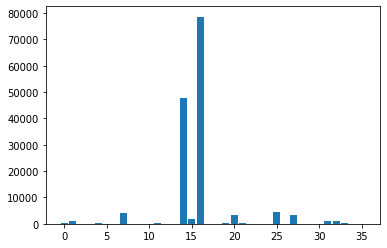

In [21]:
from collections import Counter


sub_X = pd.DataFrame()
MAX_CASES = 1

# summarize distribution
counter = Counter(df['Labels'])
for k,v in counter.items():
  per = v / len(df['Labels']) * 100
  print('Class %s - %s: n=%d (%.3f%%)' % (k, labels_dict[k], v, per))
  if v > MAX_CASES:
    MAX_CASES = v
    biggest_class = k
    print('---------> Major class %d'% k)

# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

In [22]:
# get the encoded label of NORMAL class:
NORMAL_CLASS_INDEX = 0
for key, value in labels_dict.items():
  if value == 'normal':
    NORMAL_CLASS_INDEX = key
    break

print('The encoded label of NORMAL class is', NORMAL_CLASS_INDEX)

# check if normal class is the major class. If not, add normal class to another dataframe and add another sample of Normal dataframe into X; this way normal cases are oversampled.


The encoded label of NORMAL class is 16


## **Removing duplicates from multiple classes**

- Separate each class into a set
- Remove duplicate rows that exist in multiple classes by taking the difference between classes


In [23]:
# Rename column to integers
X.set_axis(np.arange(0, len(X.columns)), axis=1, inplace=True)

# Filter out normal class and different attacks and put them in separate dfs
data = []
for label in encoded_labels:
  filt = y == label
  data.append( X.loc[filt] )
  
# condense data from each class into different sets
class_set = {}
index = 0
for item in data:
  #print(item)
  class_list = item.values.tolist()
  class_set[index] = set(tuple(i) for i in class_list)
  index += 1

# print original sets lengths
print( 'Before cleaning:')
for key, value in class_set.items():
  print( 'Class %d len: %d' % (key, len(value)) )


Before cleaning:
Class 0 len: 228
Class 1 len: 1030
Class 2 len: 39
Class 3 len: 9
Class 4 len: 412
Class 5 len: 41
Class 6 len: 11
Class 7 len: 3605
Class 8 len: 18
Class 9 len: 10
Class 10 len: 94
Class 11 len: 310
Class 12 len: 15
Class 13 len: 2
Class 14 len: 42612
Class 15 len: 1523
Class 16 len: 54148
Class 17 len: 4
Class 18 len: 5
Class 19 len: 206
Class 20 len: 2965
Class 21 len: 211
Class 22 len: 9
Class 23 len: 13
Class 24 len: 93
Class 25 len: 3862
Class 26 len: 8
Class 27 len: 2407
Class 28 len: 39
Class 29 len: 38
Class 30 len: 2
Class 31 len: 896
Class 32 len: 883
Class 33 len: 287
Class 34 len: 4
Class 35 len: 3


In [24]:
# Take the differences between 1 class and the others:
def difference_per_class ( class_number ):
  diff = class_set[class_number]
  for i in range(len(class_set)):
    # Normal class must be differentiated from all intrusion classes:
    #if class_number == NORMAL_CLASS_INDEX and i != class_number:
    #  diff -= class_set[i]
      #print('*************** NORMAL CLASS ALERT!!!!')
    #else:
      if i > class_number:
        diff -= class_set[i] 
  return diff

# Get the differences of all classes:
cleaned_class_set = {}
for key in class_set:
  cleaned_class_set[key] = difference_per_class(key)

print( 'After cleaning:')
MAX_CASES = 0
MAX_CLASS = 0
for key, value in cleaned_class_set.items():
  print( 'Class %d len: %d' % (key, len(value)) )
  if len(value) > MAX_CASES:
    MAX_CASES = len(value)
    MAX_CLASS = key

print('MAX CLASS %d has %d cases'% (MAX_CLASS, MAX_CASES))


After cleaning:
Class 0 len: 228
Class 1 len: 1005
Class 2 len: 37
Class 3 len: 8
Class 4 len: 411
Class 5 len: 41
Class 6 len: 11
Class 7 len: 3573
Class 8 len: 14
Class 9 len: 10
Class 10 len: 94
Class 11 len: 310
Class 12 len: 13
Class 13 len: 2
Class 14 len: 42612
Class 15 len: 1517
Class 16 len: 54083
Class 17 len: 4
Class 18 len: 5
Class 19 len: 206
Class 20 len: 2964
Class 21 len: 211
Class 22 len: 7
Class 23 len: 13
Class 24 len: 92
Class 25 len: 3861
Class 26 len: 8
Class 27 len: 2407
Class 28 len: 33
Class 29 len: 38
Class 30 len: 2
Class 31 len: 896
Class 32 len: 883
Class 33 len: 287
Class 34 len: 4
Class 35 len: 3
MAX CLASS 16 has 54083 cases


Data is added to 2 different dataframes based on their classes.

*   Data in the biggest class, is added to major_X, which happens to be Normal class.
*   The rest of the data is added to sub_X (Most of the time intrusion data)

Why do we save data into 2 different sets?
Data from each of these dataframes are sampled differently:
*   Data from sub_X are bootstrapped to create the same number of records per class as data from major_X.
*   Then, these data are sampled w/o replacement to get N records per class. The sampling result is stored in X df.
*   Normal data (is most likely the major data aka major_X) are sampled without replacement to get 2xN records. The result is appended in X df.

==> As a result, X includes both normal and intrusion data. Then, split X into training and testing set



In [25]:
# Append data from minor classes into 1 dataframe sub_X
sub_X = pd.DataFrame()
for key in cleaned_class_set:
  if key != MAX_CLASS:
    data_per_class = pd.DataFrame(cleaned_class_set[key])
    data_per_class['Labels'] = np.ones( len(cleaned_class_set[key]), dtype=int )*key
    sub_X = sub_X.append(data_per_class, ignore_index=True)

# Append data from major class into major_X
major_X = pd.DataFrame(cleaned_class_set[MAX_CLASS])
major_X['Labels'] = MAX_CLASS
major_X

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,Labels
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.35,0.03,9.0,79.0,1.0,1.0,1.0,0.35,0.03,1.0,0.0,120.0,0.0,0.00,0.0,0.0,0.0,0.0,20.0,0.00,16
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.32,0.00,9.0,50.0,1.0,1.0,1.0,0.01,0.04,1.0,0.0,156.0,0.0,0.00,0.0,0.0,0.0,20.0,19.0,0.00,16
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.00,0.67,9.0,3.0,1.0,0.0,1.0,1.00,0.00,2.0,0.0,2.0,0.0,0.00,0.0,0.0,0.0,127.0,43.0,0.00,16
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.00,0.04,9.0,255.0,3.0,1.0,4.0,0.02,0.00,1.0,0.0,41.0,0.5,0.00,0.0,0.0,0.0,0.0,24.0,0.00,16
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.70,0.01,9.0,181.0,1.0,1.0,1.0,0.10,0.30,1.0,0.0,10.0,0.0,0.00,0.0,0.0,0.0,0.0,54.0,0.00,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54078,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.00,0.21,1.0,255.0,1.0,0.0,1.0,0.08,0.00,1.0,0.0,13.0,0.0,1.00,1.0,1.0,0.0,0.0,24.0,1.00,16
54079,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.00,0.05,9.0,255.0,27.0,1.0,27.0,0.04,0.00,1.0,0.0,27.0,0.0,0.00,0.0,0.0,0.0,0.0,24.0,0.00,16
54080,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.00,0.00,9.0,1.0,5.0,0.0,1.0,0.93,0.52,2.0,0.6,255.0,0.0,0.00,0.0,0.0,0.0,0.0,44.0,0.00,16
54081,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.28,0.00,9.0,30.0,1.0,1.0,1.0,0.01,0.05,1.0,0.0,107.0,0.0,0.03,0.0,0.0,0.0,22.0,19.0,0.01,16


**Upsampling minor classes**

# Bootstrap minor classes from sub_X to get the same amount of MAX_CASES from major class
print('sub_X before bootstrap:',sub_X.shape)
sub_X = sub_X.groupby('Labels').sample(n = MAX_CASES, replace=True)
print('After bootstrapping:', sub_X.shape)

In [26]:
## DRAFT: append major_X into sub_X to create X w/o bootstrapping
X = sub_X.append(major_X)


**Normal sample is twice the size of an intrusion class**

# Number of cases to split into train and test sets
CASES = 10000
CASES_PER_CLASS = int(CASES/n_classes)

# Sample intrusion classes equally
X = sub_X.groupby('Labels').apply(lambda x: x.sample(CASES_PER_CLASS))
print('X len after sampling Intrusion cases:', len(X))

# Sample double the amount of normal cases
X = X.append(major_X.sample(CASES_PER_CLASS*2))  # 
print('X len after sampling Normal cases:', len(X))

In [27]:
# Reset index and then save Labels into y
X.reset_index(drop=True, inplace=True)
y = X['Labels']
X.drop(columns=['Labels'], inplace= True)
X

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26
0,0.0,1.0,0.0,0.00,0.00,0.00,0.00,0.99,0.00,4.0,253.0,38.0,1.0,38.0,0.00,0.01,1.0,0.0,255.0,0.0,0.19,1.00,1.00,0.0,805.0,24.0,0.18
1,0.0,1.0,0.0,0.00,0.00,0.01,0.01,1.00,0.00,4.0,255.0,84.0,1.0,84.0,0.00,0.00,1.0,0.0,255.0,0.0,0.32,0.98,0.98,0.0,886.0,24.0,0.32
2,0.0,1.0,0.0,0.07,0.07,0.40,0.40,1.00,0.00,9.0,255.0,35.0,1.0,35.0,0.00,0.00,1.0,0.0,255.0,0.0,0.69,0.57,0.57,0.0,902.0,24.0,0.69
3,0.0,1.0,0.0,0.59,0.59,1.00,1.00,1.00,0.00,5.0,255.0,96.0,0.0,96.0,0.00,0.00,1.0,0.0,255.0,0.0,0.38,0.00,0.00,0.0,0.0,24.0,0.38
4,0.0,1.0,0.0,0.00,0.00,0.00,0.00,0.91,0.00,4.0,231.0,8.0,1.0,8.0,0.00,0.02,1.0,0.0,255.0,0.0,0.09,1.00,1.00,0.0,2075.0,24.0,0.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115888,0.0,1.0,0.0,0.00,0.00,0.00,0.00,1.00,0.21,1.0,255.0,1.0,0.0,1.0,0.08,0.00,1.0,0.0,13.0,0.0,1.00,1.00,1.00,0.0,0.0,24.0,1.00
115889,0.0,1.0,0.0,0.00,0.00,0.00,0.00,1.00,0.05,9.0,255.0,27.0,1.0,27.0,0.04,0.00,1.0,0.0,27.0,0.0,0.00,0.00,0.00,0.0,0.0,24.0,0.00
115890,0.0,0.2,0.0,0.00,0.00,0.00,0.00,0.00,0.00,9.0,1.0,5.0,0.0,1.0,0.93,0.52,2.0,0.6,255.0,0.0,0.00,0.00,0.00,0.0,0.0,44.0,0.00
115891,0.0,1.0,0.0,0.00,0.00,0.00,0.00,0.28,0.00,9.0,30.0,1.0,1.0,1.0,0.01,0.05,1.0,0.0,107.0,0.0,0.03,0.00,0.00,0.0,22.0,19.0,0.01


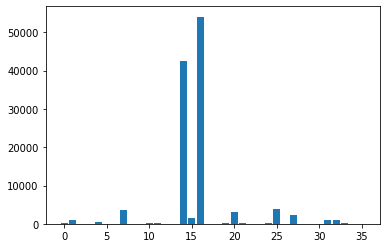

In [28]:
# summarize distribution
def print_dist(data):
  counter = Counter(data)
  # plot the distribution
  plt.bar(counter.keys(), counter.values())
  plt.show()

print_dist(y)

# **Data Partition**

Split X into train and test and ensure that the classes are stratified by classes in y

In [29]:
# Spliting into training and testing
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, stratify = y) 

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((81125, 27), (81125,), (34768, 27), (34768,))

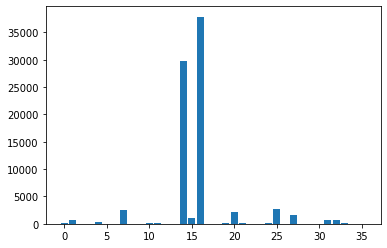

Max Class 16 has 37858 cases
Second Max Class len 29828


Before upsampling minor classes: (13439, 28)
After upsampling: (340000, 28) 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


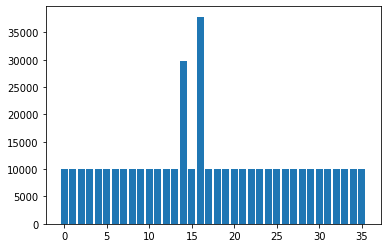

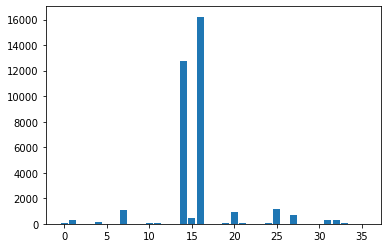

Max Class 16 has 16225 cases
Second Max Class len 12784


Before upsampling minor classes: (5759, 28)
After upsampling: (340000, 28) 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


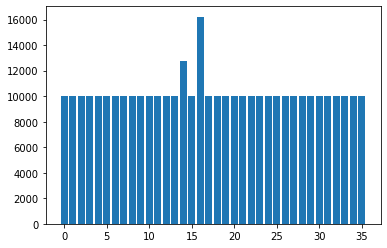

In [30]:
def over_sample(data, label):
  print_dist(label)

  ## Make sure y_train is balanced by upsampling minor classes up to the second biggest class

  # Look for the second biggest class
  label_dist = label.value_counts()
  max = 0; max_class = 0; max_2, max_2_class = 0, 0
  for i in range(len(label_dist)):
    if label_dist[i] > max:
      max_2 = max
      max_2_class = max_class
      max = label_dist[i]
      max_class = i

  print('Max Class %d has %d cases\nSecond Max Class len %d' % (max_class, max, max_2) )

  # Upsample minor classes upto the second biggest class
  filt = label == max_class
  filt2 = label == max_2_class
  major_y_train = label.loc[filt].append(label.loc[filt2])
  major_train = data.loc[data.index.isin(major_y_train.index)]

  # get the complement of the major classes indices
  minor_train = data.loc[~data.index.isin(major_y_train.index)]
  # get minor labels
  minor_train['Labels'] = label.loc[label.index.isin(minor_train.index)]
  #df[~df.index.isin(df_a.index+df_b.index)]
  print('\n\nBefore upsampling minor classes:', minor_train.shape)

  minor_train = minor_train.groupby('Labels').sample(n = 5000, replace=True) 
  minor_y_train = minor_train['Labels']
  print('After upsampling:', minor_train.shape, '\n')

  data = major_train.append(minor_train.drop(columns='Labels'), ignore_index = True)
  label = major_y_train.append(minor_y_train, ignore_index=True )
  label.astype('int32')
  print_dist(label)

  return data, label

x_train, y_train = over_sample(x_train, y_train)
x_test,  y_test  = over_sample(x_test, y_test)

In [31]:
# Binarize y_train and y_test so that we can generate classification report and get AUC score per class
from sklearn.preprocessing import label_binarize

# Binarize the output
if n_classes > 2:
  encoded_y_train = pd.DataFrame(label_binarize(y_train, classes = label_range))
  encoded_y_test  = pd.DataFrame(label_binarize(y_test, classes = label_range))
else:
  y = pd.DataFrame(y)

#n_classes = y.shape[1]

print('n_classes:', n_classes)

x_train.shape, encoded_y_train.shape, x_test.shape, encoded_y_test.shape

n_classes: 36


((407686, 27), (407686, 36), (369009, 27), (369009, 36))

In [32]:
encoded_y_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0



# **Performance Measures**


1.   Function calc_false_positive: Calculates FPR
2.   Function print_performance: Formats printing performance metrics and ROC curve for each model
3.   Function color_confusion_matrix: prints out a heatmap of confusion matrix in blue color scale
4.   Graphing overlaid ROC curves, where each one represents a model AUC score





In [33]:
from itertools import cycle

# Plot all ROC curves
def plot_ROC (performance_measures, labels_dict, model_name):
  plt.figure(figsize=(14,8))
  fpr = performance_measures.get('fpr')
  tpr = performance_measures.get('tpr')
  roc_auc = performance_measures.get('auc')
  colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'deeppink', 'green'])

  if n_classes > 2:
    plt.plot( fpr["micro"] , tpr["micro"], 
            label='micro-average (AUC = {0:0.4f})'.format(roc_auc["micro"]),
            color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
            label='macro-average (AUC = {0:0.4f})'.format(roc_auc["macro"]),
            color='navy', linestyle=':', linewidth=4)

    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                label='{0} (AUC = {1:0.4f})'
                ''.format(labels_dict[i], roc_auc[i]))
  else:
    plt.plot(fpr, tpr, lw=2,
                label='AUC = {0:0.4f}'.format(roc_auc))

  plt.plot([0, 1], [0, 1], 'k--', lw=2)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC of multi-class using '+ model_name)
  plt.legend(loc="lower right",fancybox=True, shadow=True, ncol=3, fontsize = 8)
  plt.show()

def get_cmatrix(model_name ,true_labels, pred_labels):
  if n_classes <= 2:
    return confusion_matrix(true_labels, pred_labels)
  else:
    return confusion_matrix(true_labels.values.argmax(axis=1), pred_labels.argmax(axis=1))
  

# This function prints performance metrics and ROC curve given the model name, true labels and predicted labels
def print_performance( model_name, true_labels, pred_labels, label_names):
  # rows are actual, columns are predicted
  #cmatrix = confusion_matrix(true_labels.values.argmax(axis=1), pred_labels.argmax(axis=1))
  cmatrix = get_cmatrix(model_name, true_labels, pred_labels)

  print('Confusion Matrix: \n',cmatrix)
  print('\nClassification report:', classification_report(true_labels, pred_labels, target_names = label_names, zero_division=0), sep='\n')
  print('Testing Accuracy: %.2f'% accuracy_score(true_labels, pred_labels))
  print('AUC: %.2f'% roc_auc_score(true_labels, pred_labels))
  

# Plot a heatmap of confusion matrix given the model name, a classifier model, testing data and the predicted label
def color_confusion_matrix(model_name, true_labels, pred_labels, labels):
  plt.figure(figsize=(10,10))
  #cmatrix = confusion_matrix(true_labels.values.argmax(axis=1), pred_labels.argmax(axis=1))
  cmatrix = get_cmatrix(model_name, true_labels, pred_labels)
  rows, cols = cmatrix.shape

  plt.figure(figsize=(8,8))
  plt.imshow(cmatrix, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title('Confusion Matrix of '+ model_name)
  plt.colorbar()
  tick_marks = np.arange(len(labels))
  plt.xticks(tick_marks, labels, rotation=90)
  plt.yticks(tick_marks, labels)
  plt.xlabel('Predicted Labels')
  plt.ylabel('Actual Labels')

  #large_vals = cmatrix.max()/2  comment out because there are too many classes --> no need number
  #for i in range(rows):
  #  for j in range(cols):
  #    if cmatrix[i, j] >= large_vals:
  #      color='white'
  #    else:
  #      color = 'black'
  #    plt.text(j, i, cmatrix[i, j], horizontalalignment = 'center', color= color)


## Record fpr, tpr and roc_auc info of each model on each class
def record_measures(true_labels, pred_labels):
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  if n_classes > 2:
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(true_labels.iloc[:, i], pred_labels[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve( true_labels.to_numpy().reshape(-1), pred_labels.reshape(-1))
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-avg ROC curve and area
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    measures = {}
    measures['fpr'], measures['tpr'] = fpr, tpr
    measures['auc'] = roc_auc

  else:
    measures = {}
    measures['fpr'], measures['tpr'], thresh = roc_curve(true_labels, pred_labels)
    measures['auc'] = roc_auc_score(y_train, y_pred)

  return measures
  

# Calculate either avg fpr or tpr given A DICT performance measurements of a model
# key_str can be: fpr, tpr, auc
def get_ROC_info(info, key_str):
  fpr = info.get(key_str)
  fpr_arr = []
  for key in fpr:
    if key_str == 'auc':
      fpr_arr.append(fpr[key])
    elif key != 'micro' and key != 'macro':
      if len(fpr[key]) == 2: # incase some fpr only has [0, 1]
        #print('has < 2 elements', fpr[key], type(fpr[key]))
        fpr[key] = np.insert( fpr[key], 1, 0)
      fpr_arr.append(fpr[key])
    

  # Stack the fpr of each class on top of each other
  #print('get ROC info', key_str)
  #print(fpr_arr)
  fpr_arr = pd.DataFrame(np.row_stack(fpr_arr))

  # Get avg fpr
  return fpr_arr.mean().tolist()

# Save avg fpr, tpr and auc of a model to a dict
def combine_ROC_info(info):
  model_dict = {}
  model_dict['tpr'] = get_ROC_info(info, 'tpr')
  model_dict['fpr'] = get_ROC_info(info, 'fpr')
  model_dict['auc'] = get_ROC_info(info, 'auc')
  return model_dict


# Graphing overlaid ROC curves, where each one represents a model AUC score
def graph_multi_ROC ():
  # Set color for each model
  colors = {'DT': 'magenta','RF': 'green','KNN': 'darkturquoise', 'BERT': 'deeppink', 
            'GPT': 'deeppink', 'LGBM': 'lightcoral', 'XGB': 'blue'}
  # Set marker for each model          
  markers = { 'DT': 'o--', 'RF': '+--', 'KNN': '.--', 'BERT':'<--', 'GPT': '>--',
             'LGBM': '1--', 'XGB': '2--'}
  
  plt.figure(figsize=(9,6))
## need to get the average fpr and tpr of all class
  if n_classes > 2:
    DT = combine_ROC_info(DT_test); DT_auc = DT.get('auc')[0]
    #print(DT, DT_auc)
    RF = combine_ROC_info(RF_test); RF_auc = RF.get('auc')[0]
    KNN = combine_ROC_info(KNN_test); KNN_auc = KNN.get('auc')[0]
    LGBM = combine_ROC_info(LGBM_test); LGBM_auc = LGBM.get('auc')[0]
    XGB = combine_ROC_info(XGB_test); XGB_auc = XGB.get('auc')[0]
    BERT = combine_ROC_info(BERT_test); BERT_auc = BERT.get('auc')[0]
  else:
    DT = DT_test; DT_auc = DT.get('auc')
    RF = RF_test; RF_auc = RF.get('auc')
    KNN = KNN_test; KNN_auc = KNN.get('auc')
    LGBM = LGBM_test; LGBM_auc = LGBM.get('auc')
    XGB = XGB_test; XGB_auc = XGB.get('auc')
    BERT = BERT_test; BERT_auc = BERT.get('auc')

  plt.plot(DT.get('fpr'), DT.get('tpr'), markers.get('DT'), color=colors.get('DT'),  label="DT - AUC=" + str( round(DT_auc, 4) )) 
  plt.plot(RF.get('fpr'), RF.get('tpr'), markers.get('RF'), color=colors.get('RF'),  label="RF - AUC=" + str( round(RF_auc, 4) ))
  plt.plot(KNN.get('fpr'), KNN.get('tpr'), markers.get('KNN'),color=colors.get('KNN'), label="KNN - AUC="+ str( round(KNN_auc, 4) ))
  plt.plot(LGBM.get('fpr'), LGBM.get('tpr'), markers.get('LGBM'), color=colors.get('LGBM'),  label="LGBM - AUC=" + str( round(LGBM_auc, 4) ))
  plt.plot(XGB.get('fpr'), XGB.get('tpr'), markers.get('XGB'), color=colors.get('XGB'), label="XGB - AUC="+ str( round(XGB_auc,4) ))

  plt.plot(BERT.get('fpr'),BERT.get('tpr'), markers.get('BERT'), color=colors.get('BERT'),label="BERT - AUC="+ str( round(BERT_auc,4) ))
  #plt.plot(GPT_test.get('fpr'),GPT_test.get('tpr'), markers.get('GPT'), color=colors.get('GPT'),  label="GPT-2 - AUC="+ str(GPT_test.get('auc').round(3)))

  plt.plot([0,1], [0,1], 'k--', label='Random Chances')
  plt.xlim([0.0,1.0])
  plt.ylim([0.0,1.02])
  plt.ylabel('Recall')
  plt.xlabel('False Positive Rate (1-Specificity)')
  plt.legend(loc='lower right') 
  plt.title( 'Testing ROCs on ' + DATA)
  plt.show()

# **Decision Tree**

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Create and Train DecTree model
decTree = DecisionTreeClassifier(criterion='gini', min_samples_split=10,min_samples_leaf=5,max_features='auto')
decTree = decTree.fit(x_train, encoded_y_train)

# Recording TPR and FPR for the TRAINING ROC curves
y_pred = decTree.predict(x_train)
DT_train = record_measures(encoded_y_train, y_pred)

# Predict testing data
y_predicted = decTree.predict(x_test)

# Print performance measures
print_performance('Decision Tree', encoded_y_test, y_predicted, OG_labels)

# Recording TPR and FPR for TESTING-ROC curves
DT_test = record_measures(encoded_y_test, y_predicted)

Confusion Matrix: 
 [[4768    0    0 ...    0    0    0]
 [  18 4743    0 ...    0    0    0]
 [   0    0 3691 ...    0    0    0]
 ...
 [   0    0    0 ... 4477  136   73]
 [   0    0    0 ...    0 5000    0]
 [   0    0 5000 ...    0    0    0]]

Classification report:
                 precision    recall  f1-score   support

        apache2       1.00      0.95      0.98      5000
           back       0.99      0.95      0.97      5000
buffer_overflow       0.33      0.74      0.45      5000
      ftp_write       0.00      0.00      0.00      5000
   guess_passwd       0.36      0.90      0.52      5000
     httptunnel       0.43      0.76      0.55      5000
           imap       1.00      1.00      1.00      5000
        ipsweep       0.94      0.98      0.96      5000
           land       1.00      1.00      1.00      5000
     loadmodule       0.00      0.00      0.00      5000
       mailbomb       1.00      1.00      1.00      5000
          mscan       0.84      0.94      0

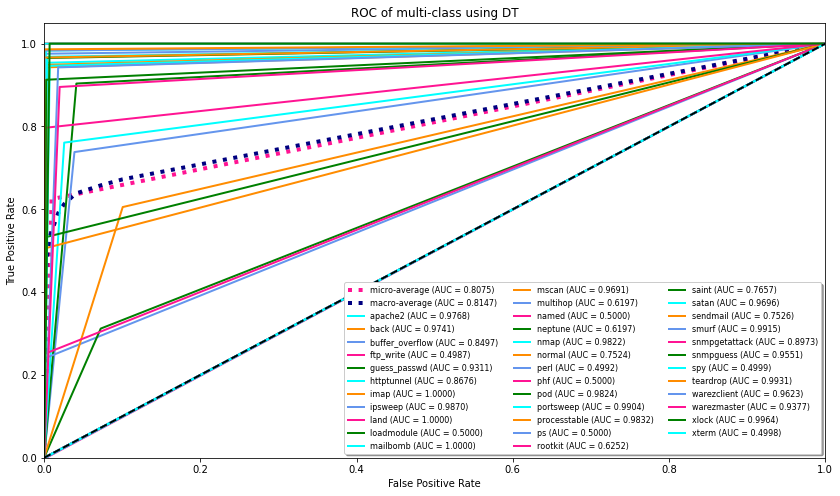

Train AUC: 0.9410 vs Test AUC: 0.8075


In [ ]:
# Print ROC Curve
plot_ROC(DT_test, labels_dict, 'DT')
if n_classes > 2:
  print('Train AUC: %.4f vs Test AUC: %.4f' %(DT_train['auc']['micro'], DT_test['auc']['micro']))
else:
  print('Train AUC: %.4f vs Test AUC: %.4f' %(DT_train['auc'], DT_test['auc']))

<Figure size 720x720 with 0 Axes>

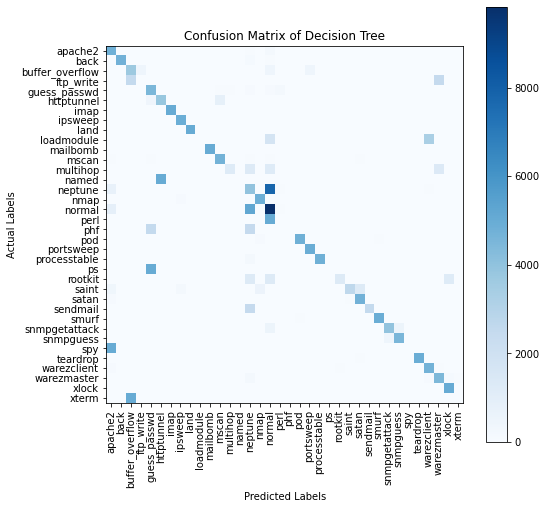

In [ ]:
# Color Confusion Matrix
color_confusion_matrix('Decision Tree', encoded_y_test, y_predicted, OG_labels)

# **Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Build model
randomForest = RandomForestClassifier(max_depth=None, min_samples_split=20, 
                                      max_features='auto', bootstrap=True,verbose=1, criterion='gini')
# Train the model with training set
randomForest.fit(x_train, encoded_y_train)

# Recording TPR and FPR for the TRAINING ROC curves
y_pred = randomForest.predict(x_train)
RF_train = record_measures(encoded_y_train, y_pred)

# Predict the labels for testing set
y_predicted = randomForest.predict(x_test)

# Print performance measures
print_performance('Random Forest', encoded_y_test, y_predicted, OG_labels)

# Recording TPR and FPR for the multi-ROC curves
RF_test = record_measures(encoded_y_test, y_predicted)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  2.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.1min finished


Confusion Matrix: 
 [[5000    0    0 ...    0    0    0]
 [  78 4912    0 ...    0    0    0]
 [1772    0 2341 ...    0    0    0]
 ...
 [ 736    0    0 ... 4264    0    0]
 [   0    0    0 ...    0 5000    0]
 [   0    0 5000 ...    0    0    0]]

Classification report:
                 precision    recall  f1-score   support

        apache2       1.00      0.97      0.98      5000
           back       1.00      0.98      0.99      5000
buffer_overflow       0.32      0.47      0.38      5000
      ftp_write       1.00      0.50      0.67      5000
   guess_passwd       1.00      0.93      0.97      5000
     httptunnel       1.00      0.76      0.86      5000
           imap       1.00      1.00      1.00      5000
        ipsweep       0.98      0.99      0.98      5000
           land       1.00      1.00      1.00      5000
     loadmodule       0.00      0.00      0.00      5000
       mailbomb       1.00      1.00      1.00      5000
          mscan       1.00      0.95      0

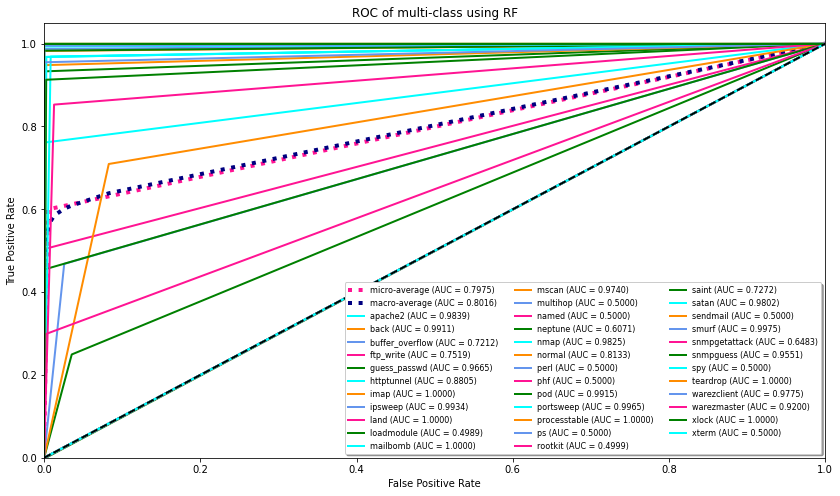

Train AUC: 0.9720 vs Test AUC: 0.7975


In [ ]:
# Print ROC Curve
plot_ROC(RF_test, labels_dict, 'RF')
if n_classes > 2:
  print('Train AUC: %.4f vs Test AUC: %.4f' %(RF_train['auc']['micro'], RF_test['auc']['micro']))
else:
  print('Train AUC: %.4f vs Test AUC: %.4f' %(RF_train['auc'], RF_test['auc']))

<Figure size 720x720 with 0 Axes>

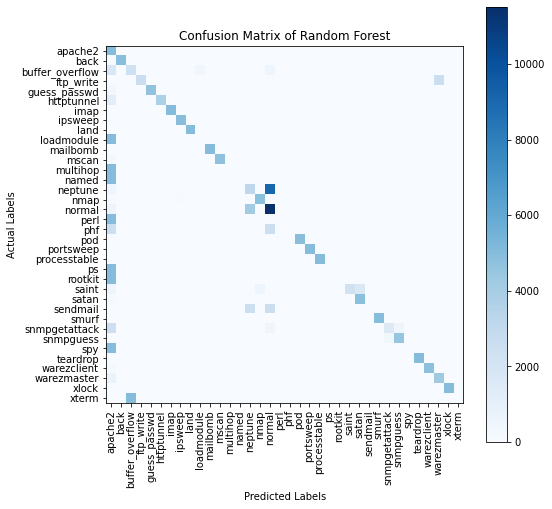

In [ ]:
# Color Confusion Matrix
color_confusion_matrix('Random Forest', encoded_y_test, y_predicted, OG_labels)

# **KNN**

Since KNN takes longer to classify this amount of data, we randomly sample 10K normal rows and 10K intrusion rows to train and test KNN.

In [ ]:
#x_train_knn, y_train_knn = x_train.sample(n=7000)

Confusion Matrix: 
 [[4843    0    0 ...    0    0    0]
 [ 118 4430    0 ...    0    0    0]
 [   0    0 3636 ...    0    0    0]
 ...
 [   0    0    0 ... 3845    0   57]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    0]]

Classification report:
                 precision    recall  f1-score   support

        apache2       1.00      0.97      0.98      5000
           back       0.97      0.89      0.92      5000
buffer_overflow       1.00      0.73      0.84      5000
      ftp_write       0.00      0.00      0.00      5000
   guess_passwd       0.84      0.88      0.86      5000
     httptunnel       0.97      0.75      0.84      5000
           imap       1.00      1.00      1.00      5000
        ipsweep       0.66      0.85      0.74      5000
           land       1.00      1.00      1.00      5000
     loadmodule       0.00      0.00      0.00      5000
       mailbomb       1.00      0.68      0.81      5000
          mscan       0.87      0.71      0

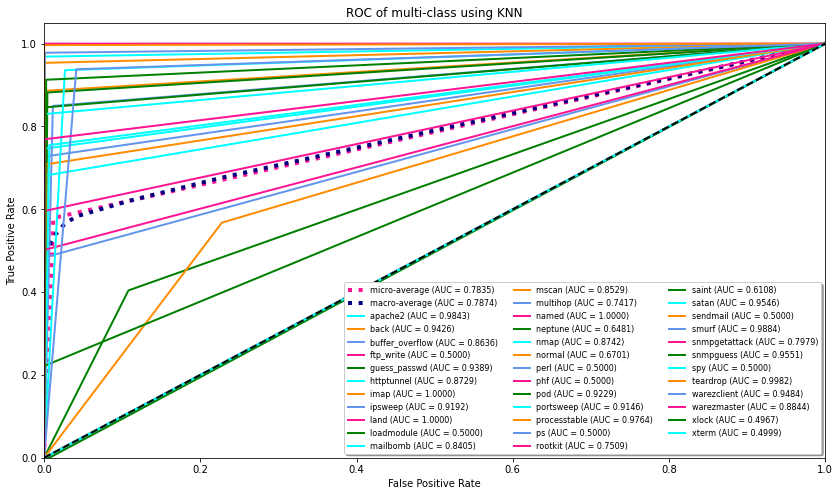

Train AUC: 0.9618 vs Test AUC: 0.7835


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Creat and Train KNN model
KNN = KNeighborsClassifier(n_neighbors=3, weights='uniform')
KNN.fit(x_train, encoded_y_train)

# Recording TPR and FPR for the TRAINING ROC curves
y_pred = KNN.predict(x_train)
KNN_train = record_measures(encoded_y_train, y_pred)

# Predict testing data
y_predicted = KNN.predict(x_test)

# Print performance measures
print_performance('KNN', encoded_y_test, y_predicted, OG_labels)

# Recording TPR and FPR for TESTING-ROC curves
KNN_test = record_measures(encoded_y_test, y_predicted)

# Print ROC Curve
plot_ROC(KNN_test, labels_dict, 'KNN')
if n_classes > 2:
  print('Train AUC: %.4f vs Test AUC: %.4f' %(KNN_train['auc']['micro'], KNN_test['auc']['micro']))
else:
  print('Train AUC: %.4f vs Test AUC: %.4f' %(KNN_train['auc'], KNN_test['auc']))

<Figure size 720x720 with 0 Axes>

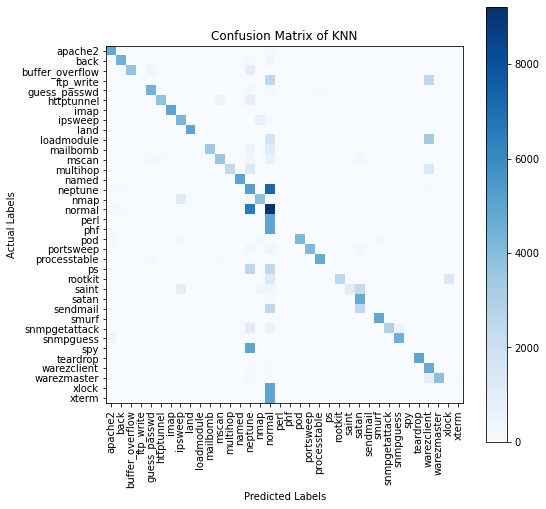

In [ ]:
# Color Confusion Matrix
color_confusion_matrix('KNN', encoded_y_test, y_predicted, OG_labels)

# **LightGBM**

Confusion Matrix: 
 [[9843  157    0 ...    0    0    0]
 [   0 9906    0 ...    0    0    0]
 [   0    0 5455 ...    0    0    0]
 ...
 [   0    0    0 ... 9544    0    0]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    0]]

Classification report:
                 precision    recall  f1-score   support

        apache2       1.00      0.98      0.99     10000
           back       0.98      0.99      0.99     10000
buffer_overflow       1.00      0.55      0.71     10000
      ftp_write       0.00      0.00      0.00     10000
   guess_passwd       0.78      0.96      0.86     10000
     httptunnel       1.00      0.84      0.91     10000
           imap       1.00      0.67      0.80     10000
        ipsweep       0.49      0.98      0.66     10000
           land       1.00      1.00      1.00     10000
     loadmodule       1.00      0.33      0.49     10000
       mailbomb       1.00      1.00      1.00     10000
          mscan       1.00      0.93      0

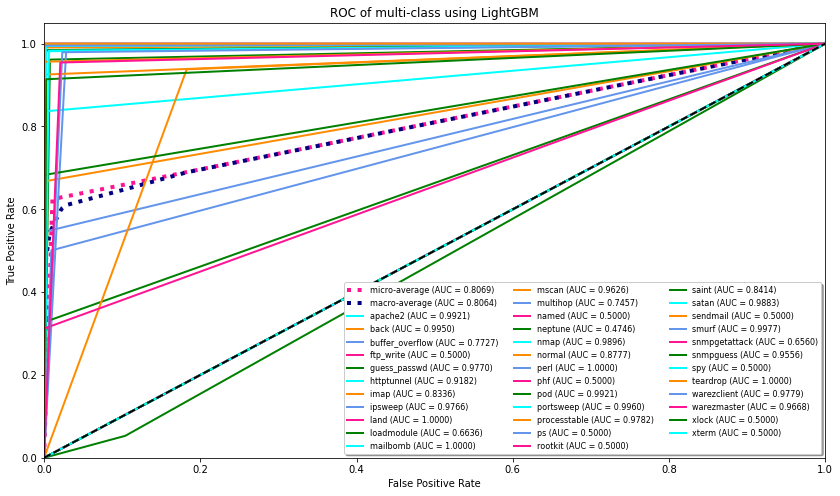

Train AUC: 0.9635 vs Test AUC: 0.8069


In [34]:
from lightgbm import LGBMClassifier

# Train LightGBM Classifier
if n_classes > 2:
  lgbmc = LGBMClassifier(objective= 'multiclass')
 
  #y_pred = label_binarize(y_pred, classes= label_range)
else:
  lgbmc = LGBMClassifier(objective= 'binary')
  
lgbmc.fit(x_train, y_train)
y_pred = lgbmc.predict(x_train)
y_pred = label_binarize(y_pred, classes= label_range)

# Recording TPR and FPR for TRAINING-ROC curves
LGBM_train = record_measures(encoded_y_train, y_pred)

# Predict test data
y_predicted = lgbmc.predict(x_test)

# Encode y_predicted: ******************************************************************
y_pred_encoded = label_binarize(y_predicted, classes= label_range)

# Print performance measures
print_performance('LightGBM', encoded_y_test, y_pred_encoded, OG_labels)

# Recording TPR and FPR for TESTING-ROC curves
LGBM_test = record_measures(encoded_y_test, y_pred_encoded)

# Print ROC Curve
plot_ROC(LGBM_test, labels_dict, 'LightGBM')
if n_classes > 2:
  print('Train AUC: %.4f vs Test AUC: %.4f' %(LGBM_train['auc']['micro'],LGBM_test['auc']['micro']))
else:
  print('Train AUC: %.4f vs Test AUC: %.4f' %(LGBM_train['auc'], LGBM_test['auc']))

<Figure size 720x720 with 0 Axes>

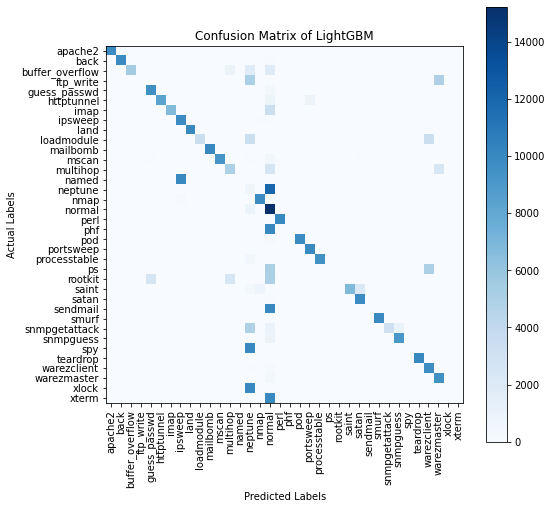

In [35]:
# Color Confusion Matrix
color_confusion_matrix('LightGBM', encoded_y_test, y_pred_encoded, OG_labels)

# **XGBoost**

Confusion Matrix: 
 [[10000     0     0 ...     0     0     0]
 [    0  9969     0 ...     0     0     0]
 [    0     0  5407 ...     0     0     0]
 ...
 [    0     0     0 ...  9437     0     0]
 [    0     0     0 ...     0     0     0]
 [    0     0 10000 ...     0     0     0]]

Classification report:
                 precision    recall  f1-score   support

        apache2       1.00      1.00      1.00     10000
           back       0.66      1.00      0.79     10000
buffer_overflow       0.22      0.54      0.31     10000
      ftp_write       0.95      0.50      0.65     10000
   guess_passwd       0.98      0.99      0.99     10000
     httptunnel       1.00      0.84      0.91     10000
           imap       1.00      0.67      0.80     10000
        ipsweep       0.98      0.98      0.98     10000
           land       1.00      1.00      1.00     10000
     loadmodule       0.00      0.00      0.00     10000
       mailbomb       1.00      1.00      1.00     10000
       

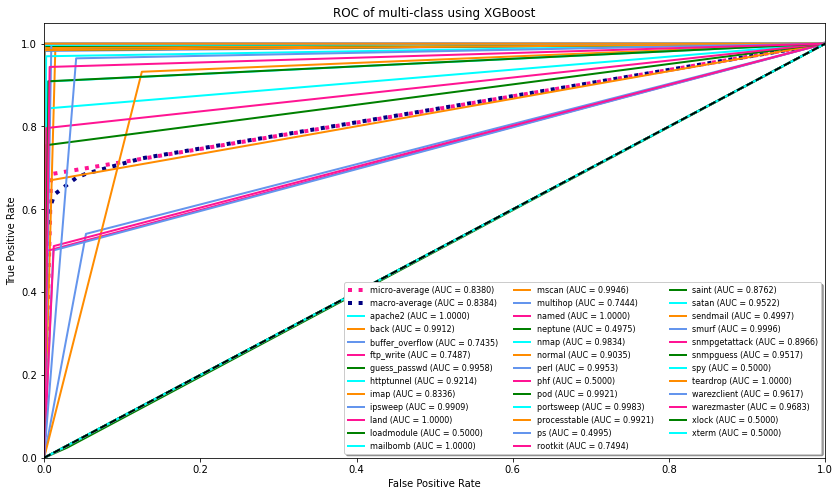

Train AUC: 0.9578 vs Test AUC: 0.8380


In [36]:
from xgboost import XGBClassifier

# Train XGBoost Classifier
xgb = XGBClassifier(eval_metric="mlogloss", objective = "multi:softprob", )  ## change from logloss to mlogloss and add objective

xgb.fit(x_train, y_train)
y_pred = xgb.predict(x_train)
y_pred = label_binarize(y_pred, classes= label_range)


# Recording TPR and FPR for TRAINING-ROC curves
XGB_train = record_measures(encoded_y_train, y_pred)

# Predict test data
y_predicted = xgb.predict(x_test)

# Encode y_predicted: ***************************
y_pred_encoded = label_binarize(y_predicted, classes= label_range)

# Print performance measures
print_performance('LightGBM', encoded_y_test, y_pred_encoded, OG_labels)

# Recording TPR and FPR for TESTING-ROC curves
XGB_test = record_measures(encoded_y_test, y_pred_encoded)

# Print ROC Curve
plot_ROC(XGB_test, labels_dict, 'XGBoost')
if n_classes > 2:
  print('Train AUC: %.4f vs Test AUC: %.4f' %(XGB_train['auc']['micro'], XGB_test['auc']['micro']))
else:
  print('Train AUC: %.4f vs Test AUC: %.4f' %(XGB_train['auc'],XGB_test['auc']))


In [37]:
type(y_pred_encoded), y_pred_encoded

(numpy.ndarray, array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 1, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0]]))

<Figure size 720x720 with 0 Axes>

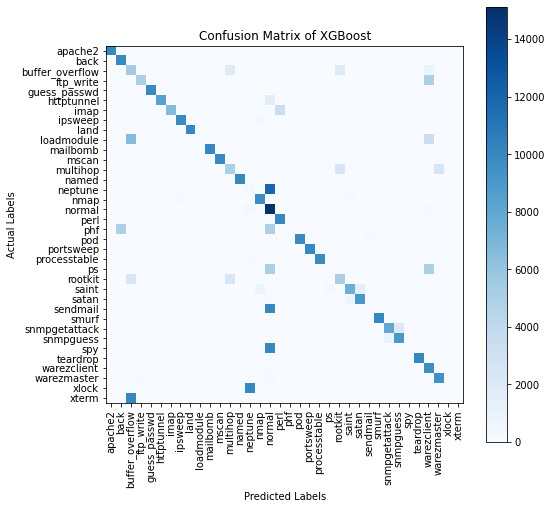

In [38]:
# Color Confusion Matrix
color_confusion_matrix('XGBoost', encoded_y_test, y_pred_encoded, OG_labels)

# **Multi-class BERT**

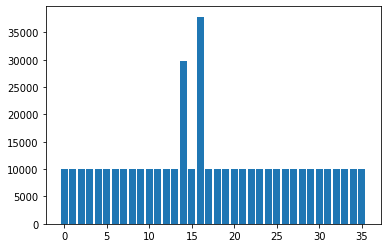

In [39]:
# plot the distribution
counter = Counter(y_train)

plt.bar(counter.keys(), counter.values())
plt.show()

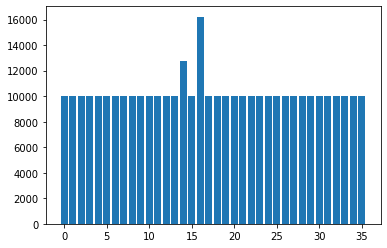

In [40]:
# plot the distribution
counter = Counter(y_test)

plt.bar(counter.keys(), counter.values())
plt.show()

## **Combining all features into a sentence**

In [41]:
train_texts = []
for i in range(x_train.shape[0]):
     train_texts.append(" ".join(np.array(x_train.iloc[i,:]).astype(str)))
train_texts = tuple(train_texts) 

In [42]:
test_texts = []
for i in range(x_test.shape[0]):
     test_texts.append(" ".join(np.array(x_test.iloc[i,:]).astype(str)))
test_texts = tuple(test_texts)

In [43]:
encoded_y_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [44]:
!pip install transformers

# Load Huggingface transformers
from transformers import TFBertModel,  BertConfig, BertTokenizerFast
# Then what you need from tensorflow.keras
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical

     |████████████████████████████████| 2.5MB 8.9MB/s 
     |████████████████████████████████| 3.3MB 41.5MB/s 
     |████████████████████████████████| 901kB 45.9MB/s 


In [45]:
### --------- Setup BERT ---------- ###
# Name of the BERT model to use
model_name = 'bert-base-uncased'
# Max length of tokens
max_length = 50

# Load transformers config and set output_hidden_states to False
config = BertConfig.from_pretrained(model_name)
config.output_hidden_states = False

# Load BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained(pretrained_model_name_or_path = model_name, config = config)

# Load the Transformers BERT model
transformer_model = TFBertModel.from_pretrained(model_name, config = config)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [46]:
### ------- Build the model ------- ###

# TF Keras documentation: https://www.tensorflow.org/api_docs/python/tf/keras/Model

# Load the MainLayer
bert = transformer_model.layers[0]

# Build your model input
input_ids = Input(shape=(max_length,), name='input_ids', dtype='int32')
inputs = {'input_ids': input_ids}

# Load the Transformers BERT model as a layer in a Keras model
bert_model = bert(inputs)[1]
dropout = Dropout(config.hidden_dropout_prob, name='pooled_output')
pooled_output = dropout(bert_model, training=False)

# Then build your model output
label = Dense(units=len(label_range), kernel_initializer=TruncatedNormal(stddev=config.initializer_range), name='label')(pooled_output)
#product = Dense(units=len(data.Product_label.value_counts()), kernel_initializer=TruncatedNormal(stddev=config.initializer_range), name='product')(pooled_output)
outputs = {'label': label}

# And combine it all in a model object
model = Model(inputs=inputs, outputs=outputs, name='BERT_MultiLabel_MultiClass')

# Take a look at the model
model.summary()

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Model: "BERT_MultiLabel_MultiClass"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 50)]              0         
_________________________________________________________________
bert (TFBertMainLayer)       TFBaseModelOutputWithPool 109482240 
_________________________________________________________________
pooled_output (Dropout)      (None, 768)               0         
_________________________________________________________________
label (Dense)                (None, 36)                27684     
Total params: 109,509,924
Trainable params: 109,509,924
Non-trainable params: 0
_________________________________________________________________


In [ ]:
### ------- Train the model ------- ###

# Set an optimizer
optimizer = Adam(
    learning_rate=5e-05,
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)

# Set loss and metrics
loss = {'label': CategoricalCrossentropy(from_logits = True)}
metric = {'label': CategoricalAccuracy('accuracy')}

# Compile the model
model.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics = metric)

# Ready output data for the model
#y_label = to_categorical(train_labels)

# Tokenize the input (takes some time)
x = tokenizer(
    text= list(train_texts),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = False,
    verbose = True)

# Fit the model
history = model.fit(
    x={'input_ids': x['input_ids']},
    y={'label': encoded_y_train},
    validation_split=0.2,
    batch_size=128,
    epochs=3)

Epoch 1/2
2549/2549 [==============================] - 3279s 1s/step - loss: 0.4888 - accuracy: 0.8322 - val_loss: 7.8207 - val_accuracy: 0.0187
Epoch 2/2
 440/2549 [====>.........................] - ETA: 41:32 - loss: 0.2732 - accuracy: 0.8706

In [ ]:
y_train_pred = model.predict(x={'input_ids': x['input_ids']}, verbose = 1)

y_train_pred_encoded = label_binarize(y_train_pred['label'].argmax(axis=1), classes= label_range)
# Recording TPR and FPR for TRAINING-ROC curves
BERT_train = record_measures( encoded_y_train, y_train_pred_encoded) 

In [ ]:
### ----- Evaluate the model ------ ###

# Ready test data
#test_y_label   = to_categorical(test_labels)

test_x = tokenizer(
    text= list(test_texts),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = False,
    verbose = True)

# Run evaluation
model_eval = model.evaluate(
    x={'input_ids': test_x['input_ids']},
    y={'label': encoded_y_test}
)

In [ ]:
y_predicted = model.predict( x={'input_ids': test_x['input_ids']}, verbose=1 )

# Encode y_predicted: ***************************
y_pred_encoded = label_binarize(y_predicted['label'].argmax(axis=1), classes= label_range)
#y_pred_encoded, encoded_y_test

In [ ]:
# Print performance measures
print_performance('BERT', encoded_y_test, y_pred_encoded, OG_labels)

# Recording TPR and FPR for TESTING-ROC curves
BERT_test = record_measures( encoded_y_test, y_pred_encoded) 

# Print ROC Curve
plot_ROC(BERT_test, labels_dict, 'BERT')


if n_classes > 2:
  print('Train AUC: %.4f vs Test AUC: %.4f' %(BERT_train['auc']['micro'], BERT_test['auc']['micro']))
else:
  print('Train AUC: %.4f vs Test AUC: %.4f' %(BERT_train['auc'],BERT_test['auc']))

In [ ]:
# Color Confusion Matrix
color_confusion_matrix('BERT', encoded_y_test, y_pred_encoded, OG_labels)


# **Graphing multi-ROC Curves**

In [ ]:
# Ploting the overlaid ROC curves on testing results:
graph_multi_ROC()

# **Note**

- Before cleaning data, BERT only get AUC = 0.86, while the other algs achieved AUC above 0.90.

- After cleaning data, BERT performance is improved to AUC = 0.92, and other algs has AUC above 0.93. However, since this dataset has 36 classes ( 1 normal and 35 intrusions), most algs do not classify normal cases well, they often mistake normal class for intrusion classes. 

--> We increased the number of cases per class from 135 to over 275, which improves f-1 score on normal class overall (F-1 Scores are above 0.77) --> still have room for improvement on normal class.
 
 --> We increase the number of cases from only normal class to see if its F1-Score can get better (Normal class vs. Intrusion classes ratio 2:1). Result: Only LightGBM and XGBoost gets better at classifying Normal class (F1-Score above 0.92), yet no improvement on DT, RF, KNN and BERT.

 --> Normal class vs. intrusion class ratio 2:1, and not removing intrusion classes from normal. Result: no difference

 --> Normal class vs. intrusion class ratio 1:1, and remove all intrusion classes from normal class. Result: Only LightGBM and XGBoost classify normal class well (Normal F1-Score above 0.88)


*   BERT note: when increasing number of training and testing sets to around 10K, BERT needs at least 10 epochs to efficiently train and validate and to achieve above 0.85 accuracy. --> Takes longer to run 
*   List item


**Next Step:**
- Narrowing down the number of classes by including only 5 or 10 classes in the training and testing sets. The purpose of this experiment is to see if BERT performance is improved when there are fewer classes. 

**Current Code Note**

This current version do not oversample minor classes. The training and testing sets are split based on stratified y. 
--> LightGBM do not work well on extremely imbalance data, so it yields the worst result. Yet BERT is doing pretty well so far

Most algorithms achieve high accuracy but low AUC due to the major class is Normal. 

Next step is to undersample major classes in the test set, so it can be balanced.

1.   List item
2.   List item



# **GPT-2**

In [ ]:
from transformers import (set_seed,
                          TrainingArguments,
                          Trainer,
                          GPT2Config,
                          GPT2Tokenizer,
                          AdamW, 
                          get_linear_schedule_with_warmup,
                          GPT2ForSequenceClassification)
import torch

#from transformers import GPT2Tokenizer, GPT2ForSequenceClassification, GPT2Config, GPT2TokenizerFast, TFGPT2Model

# Number of training epochs (authors on fine-tuning Bert recommend between 2 and 4).
epochs = 4

# Number of batches - depending on the max sequence length and GPU memory.
# For 512 sequence length batch of 10 works without cuda memory issues.
# For small sequence length can try batch of 32 or higher.
batch_size = 32

# Pad or truncate text sequences to a specific length
# if `None` it will use maximum sequence of word piece tokens allowed by model.
max_length = 30

# Look for gpu to use. Will use `cpu` by default if no gpu found.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Name of transformers model - will use already pretrained model.
# Path of transformer model - will load your own model from local disk.
model_name_or_path = 'gpt2'

# Dictionary of labels and their id - this will be used to convert.
# String labels to number ids.
#labels_ids = {'neg': 0, 'pos': 1}
labels_ids = dict( [(value, key) for key, value in labels_dict.items()] )

# How many labels are we using in training.
# This is used to decide size of classification head.
n_labels = n_classes


In [ ]:
model_config = GPT2Config.from_pretrained(pretrained_model_name_or_path=model_name_or_path, num_labels=n_labels)

# Get model's tokenizer.
print('Loading tokenizer...')
tokenizer = GPT2Tokenizer.from_pretrained(pretrained_model_name_or_path=model_name_or_path)
# default to left padding
tokenizer.padding_side = "right"
# Define PAD Token = EOS Token = 50256
tokenizer.pad_token = tokenizer.eos_token


# Get the actual model.
print('Loading model...')
model = GPT2ForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name_or_path, config=model_config)

# resize model embedding to match new tokenizer
model.resize_token_embeddings(len(tokenizer))

# fix model padding token id
model.config.pad_token_id = model.config.eos_token_id

# Load model to defined device.
model.to(device)
print('Model loaded to `%s`'%device)

In [ ]:
from tqdm.notebook import tqdm

# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # default is 1e-8.
                  )

# Total number of training steps is number of batches * number of epochs.
# `train_dataloader` contains batched data so `len(train_dataloader)` gives 
# us the number of batches.
total_steps = batch_size * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

# Store the average loss after each epoch so we can plot them.
all_loss = {'train_loss':[], 'val_loss':[]}
all_acc = {'train_acc':[], 'val_acc':[]}

# Loop through each epoch.
print('Epoch')
for epoch in tqdm(range(epochs)):
  print()
  print('Training on batches...')
  # Perform one full pass over the training set.
  train_labels, train_predict, train_loss = train(train_texts, optimizer, scheduler, device)
  train_acc = accuracy_score(train_labels, train_predict)

  # Get prediction form model on validation data. 
  print('Validation on batches...')
  valid_labels, valid_predict, val_loss = validation(test_texts, device)
  val_acc = accuracy_score(valid_labels, valid_predict)

  # Print loss and accuracy values to see how training evolves.
  print("  train_loss: %.5f - val_loss: %.5f - train_acc: %.5f - valid_acc: %.5f"%(train_loss, val_loss, train_acc, val_acc))
  print()

  # Store the loss value for plotting the learning curve.
  all_loss['train_loss'].append(train_loss)
  all_loss['val_loss'].append(val_loss)
  all_acc['train_acc'].append(train_acc)
  all_acc['val_acc'].append(val_acc)

# Plot loss curves.
plot_dict(all_loss, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])

# Plot accuracy curves.
plot_dict(all_acc, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])

In [ ]:
#tokenizer = GPT2Tokenizer.from_pretrained('microsoft/DialoGPT-small')

In [ ]:
# Padding sequences from the right to a max length of 20
tokenizer.padding_side = "right"
tokenizer.pad_token = tokenizer.eos_token
train_tokens = tokenizer(train_texts,return_tensors='pt',truncation=True,padding=True,max_length=30)
test_tokens = tokenizer(test_texts,return_tensors='pt',truncation=True,padding=True,max_length=30)

In [ ]:
# Following is to convert List of words to list of numbers. (Words are replaced by their index in dictionar)

train_tokens_ids = train_tokens.input_ids
test_tokens_ids = test_tokens.input_ids

train_tokens_ids.shape, test_tokens_ids.shape

In [ ]:
train_masks = train_tokens.attention_mask
test_masks = test_tokens.attention_mask

**Create GPT-2 Classifer**

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

In [ ]:

class GTP2BinaryClassifier(nn.Module):
    def __init__(self, dropout=0.1):
        super(GTP2BinaryClassifier, self).__init__()
        self.gtp2 = GPT2ForSequenceClassification.from_pretrained('microsoft/DialoGPT-small')
      
    def train_m(self,x,y,train_mask,epochs,batchsize):
      train_tokens_tensor = torch.tensor(x)
      #train_y_tensor = torch.tensor(y.reshape(-1, 1)).long()
      train_y_tensor = torch.tensor(y).long()
      train_masks_tensor = torch.tensor(train_mask)

      train_dataset = TensorDataset(train_tokens_tensor, train_masks_tensor, train_y_tensor)
      train_sampler = RandomSampler(train_dataset)
      train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batchsize) 


      # param_optimizer = list(self.gtp2.parameters()) 
      # optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]
      optimizer = Adam(self.gtp2.parameters(), lr=5e-5)
      for epoch_num in range(epochs):
          self.gtp2.train() # Training Flag
          train_loss = 0
          for step_num, batch_data in enumerate(train_dataloader):
              
              # Load batch on device memory
              token_ids, masks, labels = tuple(t.to(device) for t in batch_data)
              self.zero_grad()

              # Get the output of the model for provided input
              outputs = self.gtp2(token_ids,attention_mask=masks,labels=labels)
              loss, logits = outputs[:2]
              # logits = self(token_ids, masks)
              
              # Total Loss
              train_loss += loss.item()
              
              # Backward pass the loss
              loss.backward()
              torch.nn.utils.clip_grad_norm_(self.gtp2.parameters(), 1.0)
              
              optimizer.step()
              logits = logits.detach().cpu().numpy()

              clear_output(wait=True)
        
              print('Epoch: ', epoch_num + 1)
              print("\r" + "{0}/{1} loss: {2} ".format(step_num, len(train_labels) / batchsize, train_loss / (step_num + 1)))
        

In [ ]:
gtp_clf = GTP2BinaryClassifier()
gtp_clf = gtp_clf.cuda()

In [ ]:


train_y = np.array(encoded_y_train) == 1
train_y.shape

In [ ]:
train_tokens_ids, train_tokens_ids.shape

In [ ]:
# Configure the Padding token id
gtp_clf.gtp2.config.pad_token_id = tokenizer.eos_token_id
gtp_clf.train_m(train_tokens_ids,train_y,train_masks,4, 32)

**Evaluate on Testing Set**

In [ ]:
test_tokens_tensor = torch.tensor(test_tokens_ids)
test_y_tensor = torch.tensor(test_y.reshape(-1, 1)).long()

test_masks_tensor = torch.tensor(test_masks)


test_dataset = TensorDataset(test_tokens_tensor, test_masks_tensor, test_y_tensor)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=16)


In [ ]:
# Evaluate Model
gtp_clf.eval() # Define eval
gpt_predicted = [] # Store Result
with torch.no_grad():
    for step_num, batch_data in enumerate(test_dataloader):

        token_ids, masks, labels = tuple(t.to(device) for t in batch_data)

        # ----------------------------------------------------------------
        outputs = gtp_clf.gtp2(token_ids,attention_mask=masks,labels=labels)
        loss, logits = outputs[:2]
        numpy_logits = logits.detach().cpu().numpy()
        # ----------------------------------------------------------------
        gpt_predicted +=list(numpy_logits.argmax(axis=-1).flatten().tolist())

In [ ]:
print_performance('GPT2',test_y, gpt_predicted)

# Recording TPR and FPR for the TESTING-ROC curves
GPT_test = {}
GPT_test['fpr'], GPT_test['tpr'], thresh = roc_curve(test_y, gpt_predicted)
GPT_test['auc'] = roc_auc_score(test_y, gpt_predicted) 